Dataset used:
https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads

In [2]:
! pip install torch matplotlib numpy pandas pytorch_lightning scikit-learn torchvision

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached scipy-1.16.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 273.7 kB/s  0:00:03.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 191.0 kB/s  0:00:41194.4 kB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 229.3 kB/s  0:00:089.5 kB/s eta 0:00:02:03
Using cached scipy-1.16.3-cp312-cp312-macosx_14_0_arm64.whl (20.9 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 153.3 kB/s  0:00:05.7 kB/s eta 0:00:02:03
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [pytorch_lightning]0m 18/19 [pytorch_lightning]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report

from load_dataset import get_mvtec_loader
from CAE import CAE
from VAE import VAE
from ViTVAE import ViTVAE
from VAE_GRF import VAE_GRF

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")


Using MPS device


In [4]:
CATEGORY = 'bottle'
BATCH_SIZE = 32
IMAGE_SIZE = 256
ROOT_DIR = '../mvtec_anomaly_detection'

train_loader = get_mvtec_loader(ROOT_DIR, CATEGORY, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, split='train')
test_loader = get_mvtec_loader(ROOT_DIR, CATEGORY, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, split='test')

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 7
Test batches: 3


In [ ]:
model = CAE(input_channels=3, lr=1e-3)

trainer = pl.Trainer(max_epochs=50, accelerator="auto", devices=1)
trainer.fit(model, train_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/jacekurbanowicz/Desktop/WIET/um/AE-Comp/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/jacekurbanowicz/Desktop/WIET/um/AE-Comp/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined

Epoch 49: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s, v_num=0]


ROC AUC: 0.6103


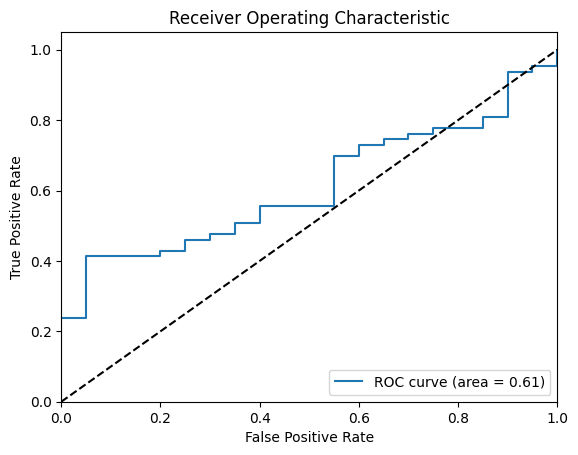

In [ ]:
model.eval()
model.to(device)

anomaly_scores = []
true_labels = []

criterion = nn.MSELoss(reduction='none')

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, images)
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        
        anomaly_scores.extend(loss.cpu().numpy())
        true_labels.extend(labels.numpy())

anomaly_scores = np.array(anomaly_scores)
true_labels = np.array(true_labels)

roc_auc = roc_auc_score(true_labels, anomaly_scores)
print(f"ROC AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

precision, recall, thresholds = precision_recall_curve(true_labels, anomaly_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]

print(f"Best Threshold: {best_threshold}")

predictions = (anomaly_scores > best_threshold).astype(int)
print(classification_report(true_labels, predictions, target_names=['Good', 'Anomaly']))


Best Threshold: 0.0013029786059632897
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00        20
     Anomaly       0.76      0.98      0.86        63

    accuracy                           0.75        83
   macro avg       0.38      0.49      0.43        83
weighted avg       0.57      0.75      0.65        83



# Variational Autoencoder (VAE)


In [11]:
vae_model = VAE(input_channels=3, latent_dim=1024, lr=1e-3)

vae_trainer = pl.Trainer(max_epochs=50, accelerator="auto", devices=1)
vae_trainer.fit(vae_model, train_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name         | Type       | Params | Mode  | FLOPs
------------------------------------------------------------
0 | encoder_conv | Sequential | 690 K  | train | 0    
1 | fc_mu        | Linear     | 67.1 M | train | 0    
2 | fc_logvar    | Linear     | 67.1 M | train | 0    
3 | fc_decode    | Linear     | 67.2 M | train | 0    
4 | decoder_conv | Sequential | 689 K  | train | 0    
------------------------------------------------------------
202 M     Trainable params
0         Non-trainable params
202 M     Total params
811.097   Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 49: 100%|██████████| 7/7 [00:07<00:00,  0.90it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:11<00:00,  0.63it/s, v_num=2]


VAE ROC AUC: 0.7937


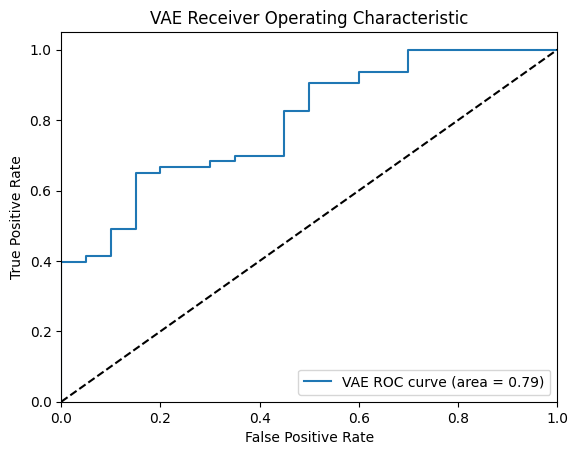

In [ ]:
vae_model.eval()
vae_model.to(device)

vae_anomaly_scores = []
vae_true_labels = []

criterion = nn.MSELoss(reduction='none')

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs, _, _ = vae_model(images)
        
        loss = criterion(outputs, images)
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        
        vae_anomaly_scores.extend(loss.cpu().numpy())
        vae_true_labels.extend(labels.numpy())

vae_anomaly_scores = np.array(vae_anomaly_scores)
vae_true_labels = np.array(vae_true_labels)

vae_roc_auc = roc_auc_score(vae_true_labels, vae_anomaly_scores)
print(f"VAE ROC AUC: {vae_roc_auc:.4f}")

fpr, tpr, _ = roc_curve(vae_true_labels, vae_anomaly_scores)
plt.figure()
plt.plot(fpr, tpr, label=f'VAE ROC curve (area = {vae_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VAE Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
precision, recall, thresholds = precision_recall_curve(vae_true_labels, vae_anomaly_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold_vae = thresholds[np.argmax(f1_scores[:-1])]

print(f"Best Threshold VAE: {best_threshold_vae}")

predictions_vae = (vae_anomaly_scores > best_threshold_vae).astype(int)
print(classification_report(vae_true_labels, predictions_vae, target_names=['Good', 'Anomaly']))


Best Threshold VAE: 0.0016191102331504226
              precision    recall  f1-score   support

        Good       0.86      0.30      0.44        20
     Anomaly       0.82      0.98      0.89        63

    accuracy                           0.82        83
   macro avg       0.84      0.64      0.67        83
weighted avg       0.83      0.82      0.78        83



# Vision Transformer VAE (ViT-VAE)


In [15]:
vit_vae_model = ViTVAE(image_size=IMAGE_SIZE, patch_size=32, input_channels=3, 
                       dim=256, depth=4, heads=4, mlp_dim=512, latent_dim=512, lr=1e-3)

vit_vae_trainer = pl.Trainer(max_epochs=50, accelerator="auto", devices=1)
vit_vae_trainer.fit(vit_vae_model, train_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/jacekurbanowicz/Desktop/WIET/um/AE-Comp/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name                | Type               | Params | Mode  | FLOPs
---------------------------------------------------------------------------
0 | to_patch_embedding  | Sequential         | 786 K  | train | 0    
1 | transformer_encoder | TransformerEncoder | 2.1 M  | train | 0    
2 | fc_mu               | Linear             | 131 K  | train | 0    
3 | fc_logvar           | Linear             | 131 K  | train | 0    
4 | decoder_input       | Linear             | 8.4 M  | train | 0    

Epoch 49: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s, v_num=3]


ViT-VAE ROC AUC: 0.8325


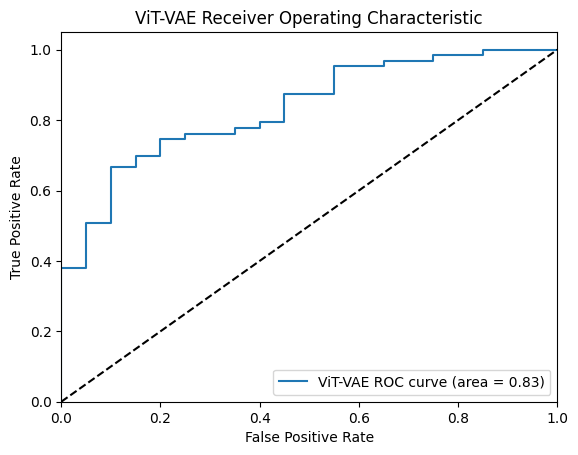

In [16]:
vit_vae_model.eval()
vit_vae_model.to(device)

vit_anomaly_scores = []
vit_true_labels = []

criterion = nn.MSELoss(reduction='none')

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs, _, _ = vit_vae_model(images)
        
        # Calculate MSE per image
        loss = criterion(outputs, images)
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        
        vit_anomaly_scores.extend(loss.cpu().numpy())
        vit_true_labels.extend(labels.numpy())

vit_anomaly_scores = np.array(vit_anomaly_scores)
vit_true_labels = np.array(vit_true_labels)

# Calculate ROC AUC
vit_roc_auc = roc_auc_score(vit_true_labels, vit_anomaly_scores)
print(f"ViT-VAE ROC AUC: {vit_roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(vit_true_labels, vit_anomaly_scores)
plt.figure()
plt.plot(fpr, tpr, label=f'ViT-VAE ROC curve (area = {vit_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ViT-VAE Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [18]:
precision, recall, thresholds = precision_recall_curve(vit_true_labels, vit_anomaly_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold_vit = thresholds[np.argmax(f1_scores[:-1])]

print(f"Best Threshold ViT-VAE: {best_threshold_vit}")

predictions_vit = (vit_anomaly_scores > best_threshold_vit).astype(int)
print(classification_report(vit_true_labels, predictions_vit, target_names=['Good', 'Anomaly']))


Best Threshold ViT-VAE: 0.002069677459076047
              precision    recall  f1-score   support

        Good       0.69      0.45      0.55        20
     Anomaly       0.84      0.94      0.89        63

    accuracy                           0.82        83
   macro avg       0.77      0.69      0.72        83
weighted avg       0.81      0.82      0.80        83



## VAE with Gaussian Random Field (VAE-GRF)

In [19]:
from VAE_GRF import VAE_GRF

vae_grf_model = VAE_GRF(input_channels=3, latent_channels=16, lr=1e-3)

vae_grf_trainer = pl.Trainer(max_epochs=50, accelerator="auto", devices=1)
vae_grf_trainer.fit(vae_grf_model, train_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/jacekurbanowicz/Desktop/WIET/um/AE-Comp/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type       | Params | Mode  | FLOPs
------------------------------------------------------------
0 | encoder_conv | Sequential | 690 K  | train | 0    
1 | conv_mu      | Conv2d     | 36.9 K | train | 0    
2 | conv_logvar  | Conv2d     | 36.9 K | train | 0    
3 | conv_decode  | Conv2d     | 37.1 K | train | 0    
4 | decoder_conv | Sequential | 689 K  | train | 0    
------------------------------------------------------------
1.5 M     Trainable params
0         Non-tr

Epoch 49: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s, v_num=4]


VAE-GRF ROC AUC: 0.7571
Best Threshold VAE-GRF: 0.0041


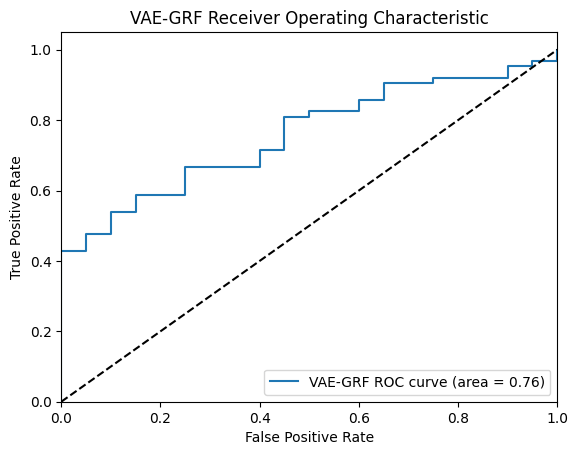

In [22]:
vae_grf_model.eval()
vae_grf_model.to(device)

vae_grf_anomaly_scores = []
vae_grf_true_labels = []

criterion = nn.MSELoss(reduction='none')

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs, _, _ = vae_grf_model(images)
        
        loss = criterion(outputs, images)
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        
        vae_grf_anomaly_scores.extend(loss.cpu().numpy())
        vae_grf_true_labels.extend(labels.numpy())

vae_grf_anomaly_scores = np.array(vae_grf_anomaly_scores)
vae_grf_true_labels = np.array(vae_grf_true_labels)

vae_grf_roc_auc = roc_auc_score(vae_grf_true_labels, vae_grf_anomaly_scores)
print(f"VAE-GRF ROC AUC: {vae_grf_roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(vae_grf_true_labels, vae_grf_anomaly_scores)
optimal_idx = np.argmax(tpr - fpr)
best_threshold_vae_grf = thresholds[optimal_idx]
print(f"Best Threshold VAE-GRF: {best_threshold_vae_grf:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f'VAE-GRF ROC curve (area = {vae_grf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VAE-GRF Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
predictions_vae_grf = (vae_grf_anomaly_scores > best_threshold_vae_grf).astype(int)
print("VAE-GRF Classification Report:")
print(classification_report(vae_grf_true_labels, predictions_vae_grf))

VAE-GRF Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.90      0.53        20
           1       0.94      0.52      0.67        63

    accuracy                           0.61        83
   macro avg       0.66      0.71      0.60        83
weighted avg       0.81      0.61      0.64        83

